In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# EDA

In [ ]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Almost immediately it is visible that in our dataset most variables are integers.

<Axes: xlabel='price_range', ylabel='count'>

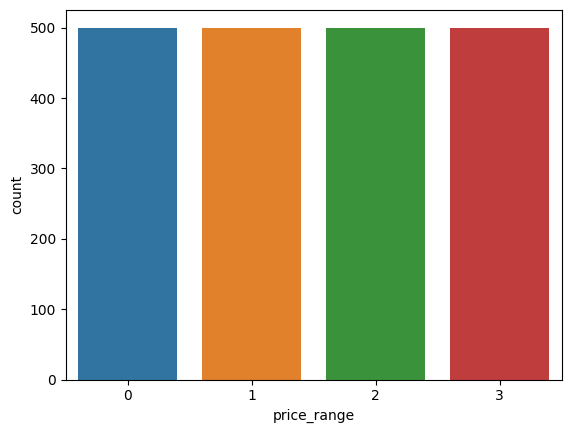

In [ ]:
sns.countplot(x=data.price_range)

By just plotting the target attribute we have discovered we should not have any problems connected to the disbalance distribution of the target attribute.


Accuracy metric should be a reasonable metric for model performance estimation.

In [ ]:
predictors = data.columns.drop('price_range')
response = data[['price_range']].columns[0]

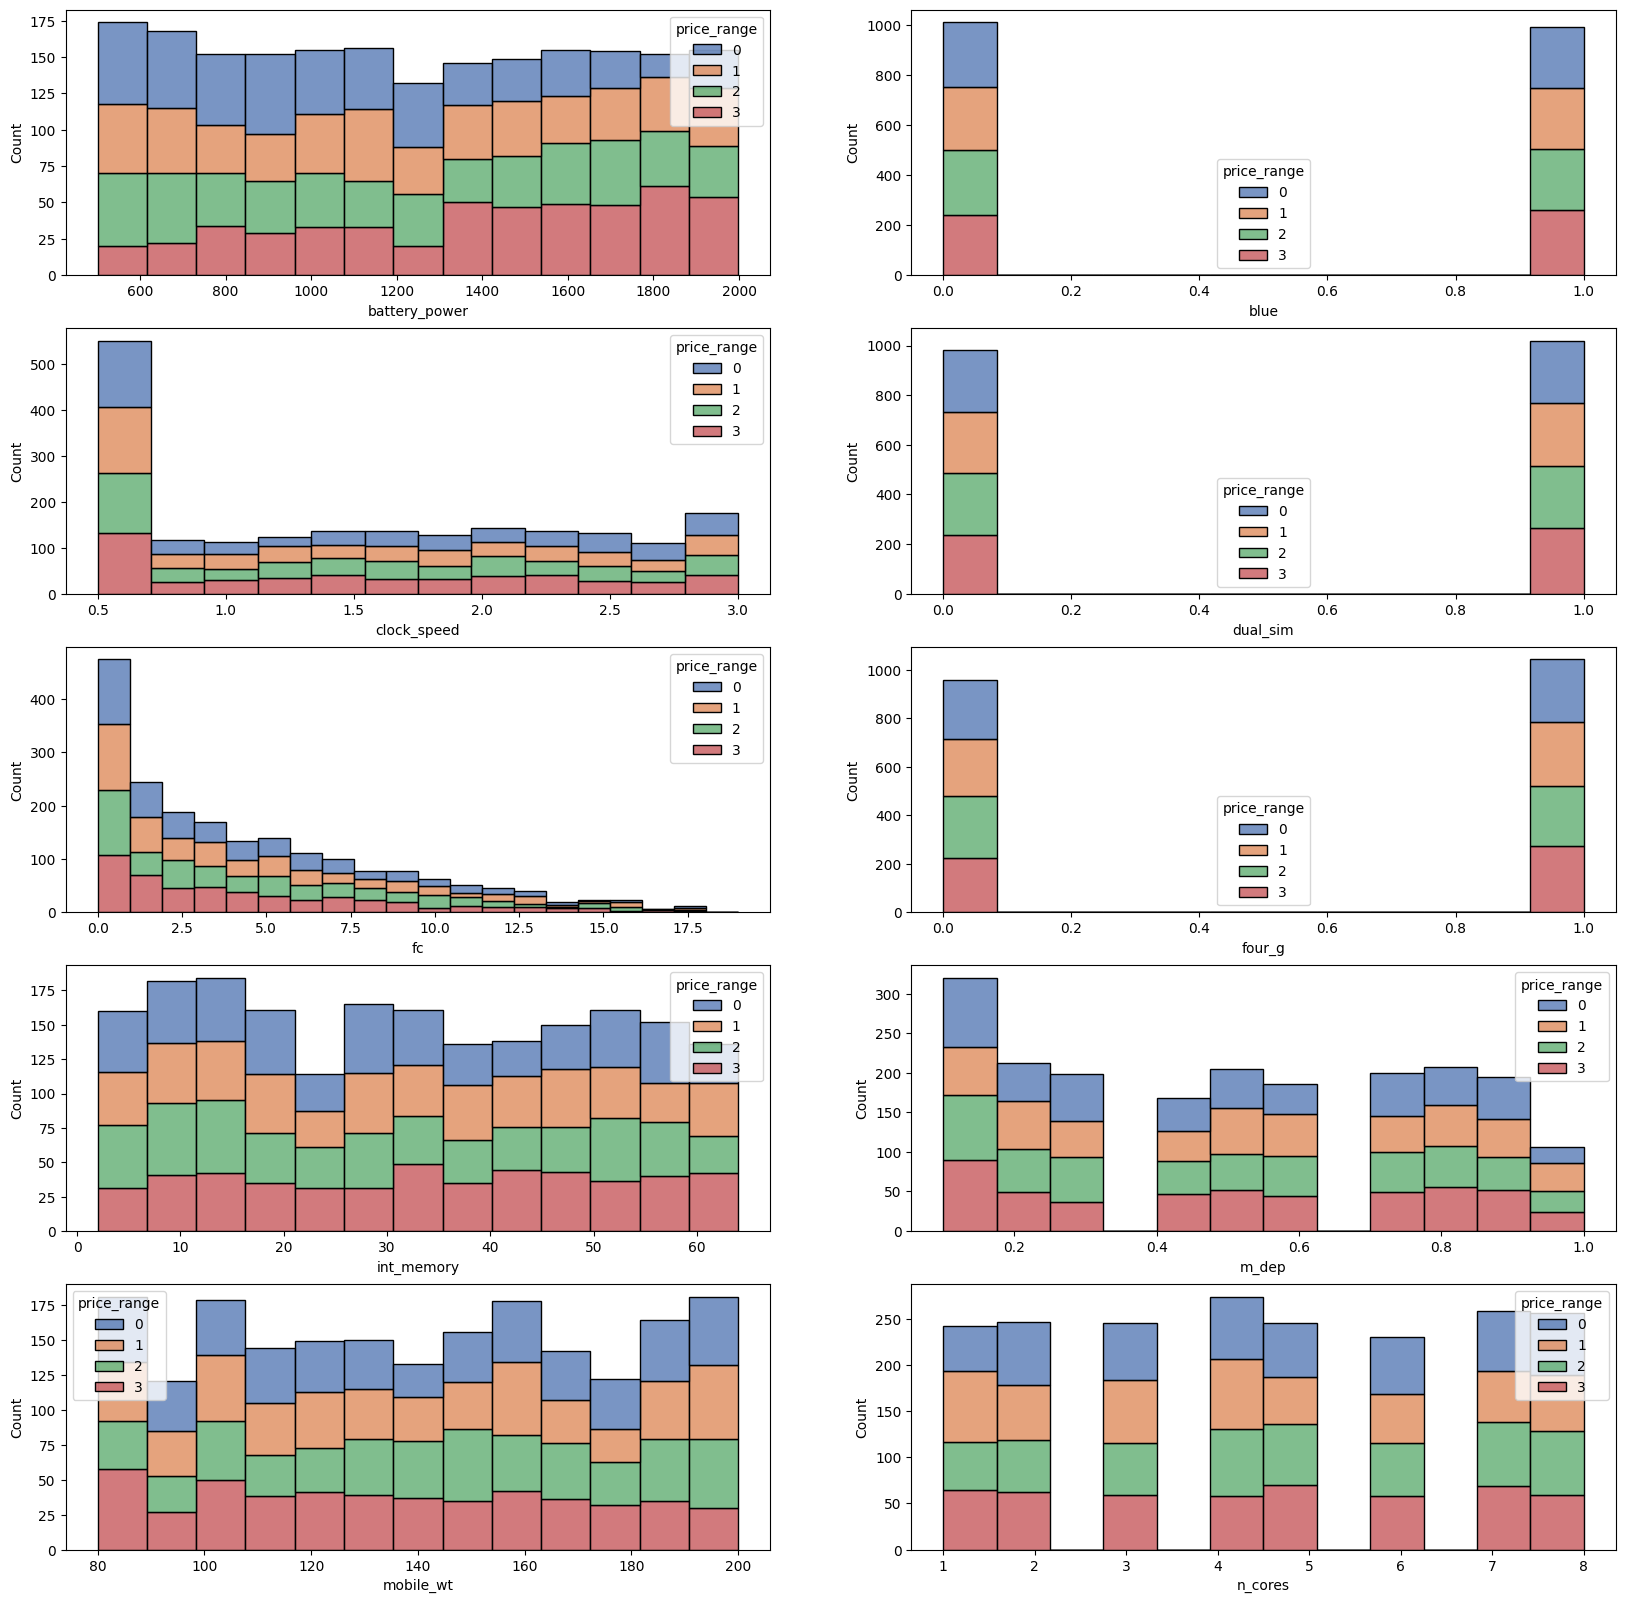

In [ ]:
# Functions to easily customize histplot, boxplot and pie, if necessary

def printHist(data, predictor, response, ax_):
  sns.histplot(data=data, x=predictor, ax=ax_, hue=response, palette=sns.color_palette("deep", n_colors=4), multiple='stack')

def printBox(data, predictor, ax_):
  sns.boxplot(data=data, x=predictor, ax=ax_)

def printPie(data, predictor, ax_):
  ax_.pie(x=data[predictor].value_counts(), labels=data[predictor].value_counts().index)
  ax_.set_title(predictor)

_, axs = plt.subplots(5, 2, figsize=(20, 20))


for predictor, ax_ in zip(predictors[:10], axs.flatten()):
  printHist(data, predictor, response, ax_)

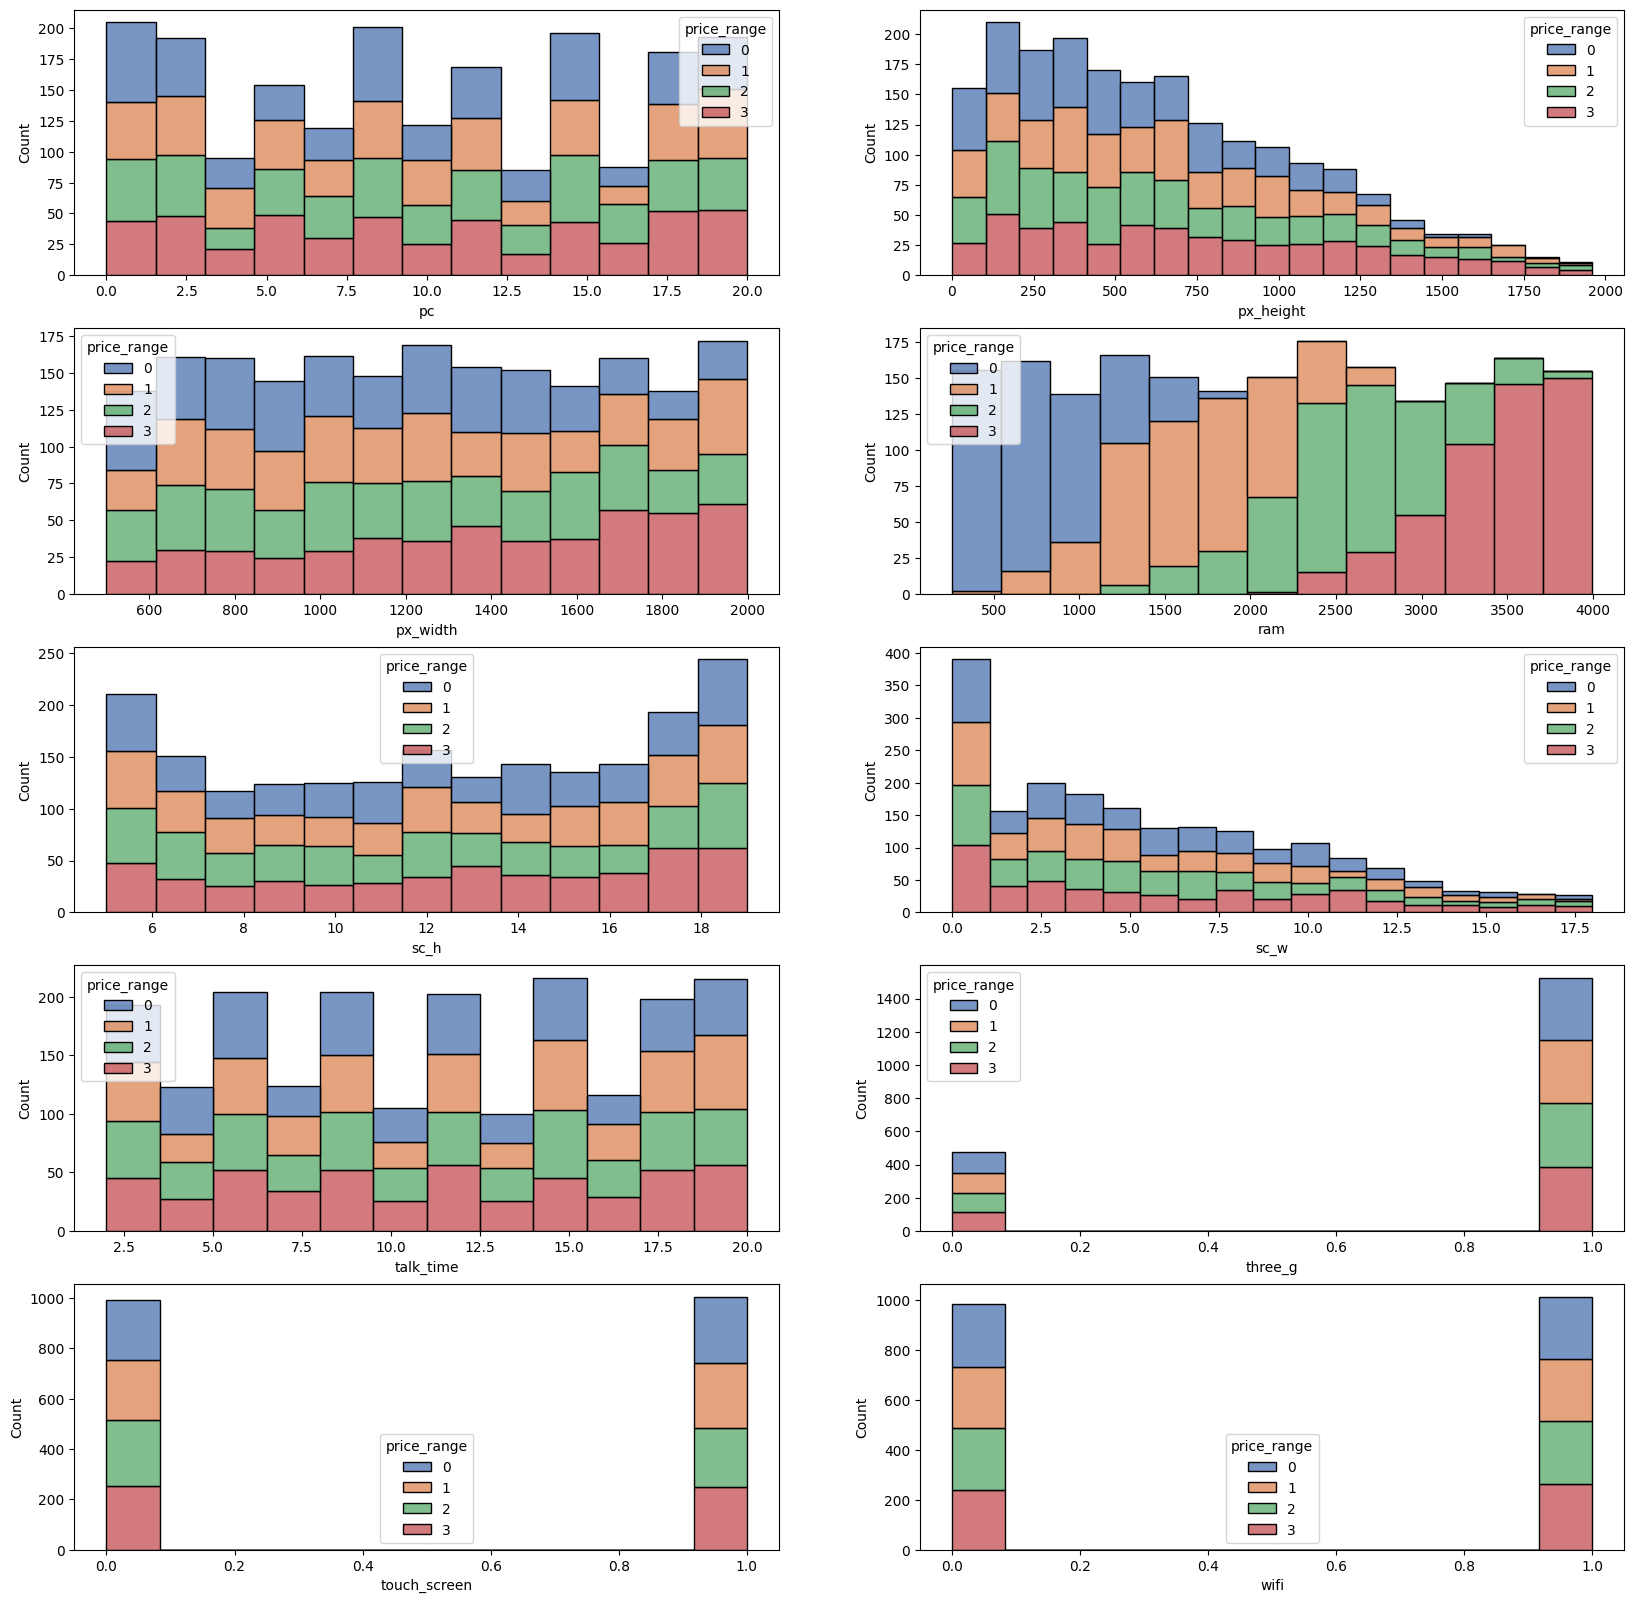

In [ ]:
_, axs = plt.subplots(5, 2, figsize=(20, 20))

for predictor, ax_ in zip(predictors[10:], axs.flatten()):
  printHist(data, predictor, response, ax_)

By analyzing histograms of the predictors we can observe that although some variables were initially identified as integers, they are boolean.

From visual analysis, we can infer that there are no significant outliers strongly distorting the distribution of attributes.

Most attributes, which are not boolean, resemble uniform distribution. The only attributes with distributions that do not resemble uniformity are fc, clock_speed, px_height, and sc_w, which are strongly left-skewed. The sc_h attribute also stands out among other attributes due to its U-shaped distribution.

Variables distribution dont change from class to class, apart from RAM, where higher price_range results in higher mean of RAM values.

In [ ]:
data_nunique = data[predictors].nunique(axis=0)
data_nunique

battery_power    1094
blue                2
clock_speed        26
dual_sim            2
fc                 20
four_g              2
int_memory         63
m_dep              10
mobile_wt         121
n_cores             8
pc                 21
px_height        1137
px_width         1109
ram              1562
sc_h               15
sc_w               19
talk_time          19
three_g             2
touch_screen        2
wifi                2
dtype: int64

Although clock_speed and m_dep are only float variables they take on limited values.


The only variables that are truly continuous are ram, px_heigt, px_width, battery_power.

In [ ]:
boolean_variables = data_nunique[data_nunique==2].index
nonboolean_variables = set(predictors) - set(boolean_variables)
boolean_variables

Index(['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'], dtype='object')

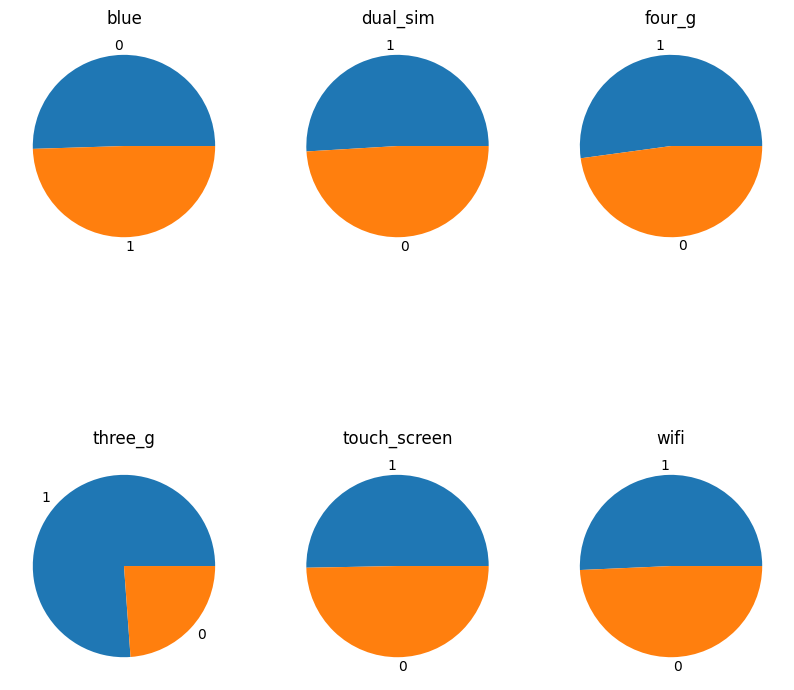

In [ ]:
_, axs = plt.subplots(2, 3, figsize=(10, 10))

for predictor, ax_ in zip(boolean_variables, axs.flatten()):
  printPie(data, predictor, ax_)

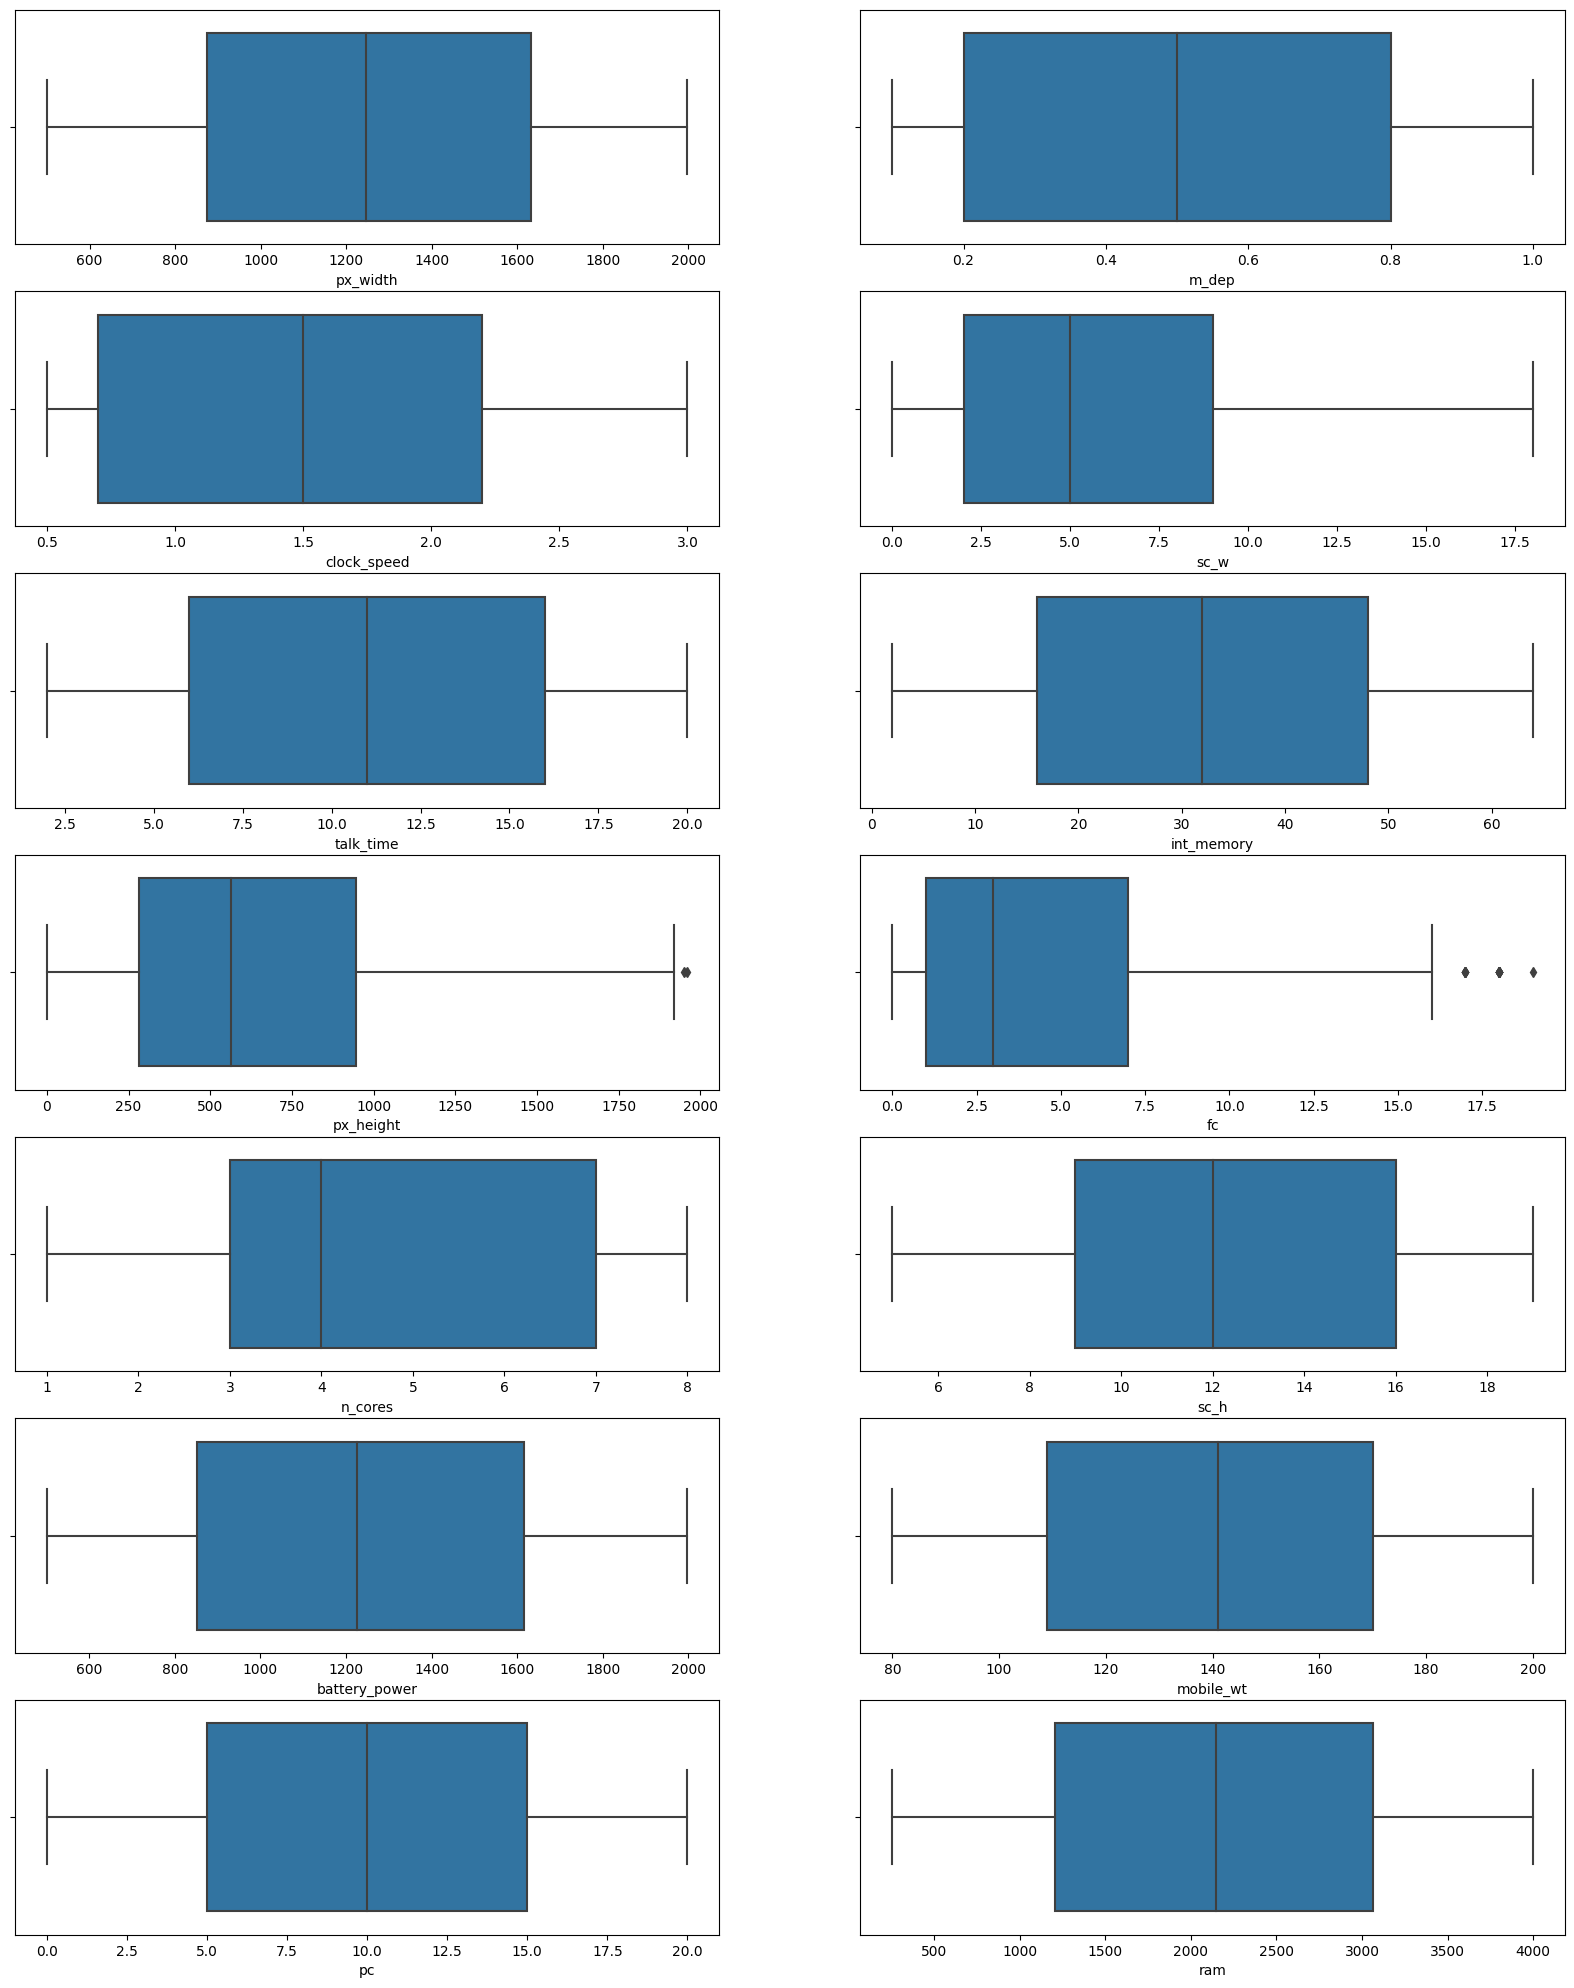

In [ ]:
_, axs = plt.subplots(7, 2, figsize=(20, 25))

for predictor, ax_ in zip(nonboolean_variables, axs.flatten()):
  printBox(data, predictor, ax_)

Visually looking at box plots we can observe that there are some outliers.


Previously looking at attribute distributions we stated that there are no strong outliers that distort distribution, so we will assume that these outliers are not anomalies but rather extreme values of attributes. Having said that, we still need to process them, because they can impact some of our models.


We will winsorize this observation to bring them to a range that is in [Q1-IQR, Q3+IQR] range.

In [ ]:
# Reduces right outliers to IQR + Q3
def IQR_filter_right_outlieres(data, column):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  data[column][(data[column] > Q3 + IQR)] = IQR + Q3


IQR_filter_right_outlieres(data, 'fc')
IQR_filter_right_outlieres(data, 'px_height')

<ipython-input-11-ee407ba730f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][(data[column] > Q3 + IQR)] = IQR + Q3
<ipython-input-11-ee407ba730f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][(data[column] > Q3 + IQR)] = IQR + Q3


In [ ]:
def plotCorr(corr, ax=None):
  plt.figure(figsize = (12,10))
  sns.heatmap(corr, vmin=-1, vmax=1, cmap="vlag", ax=ax)


per_corr = data[predictors].corr()
spear_corr = data[predictors].corr('spearman')
kend_corr = data[predictors].corr('kendall')

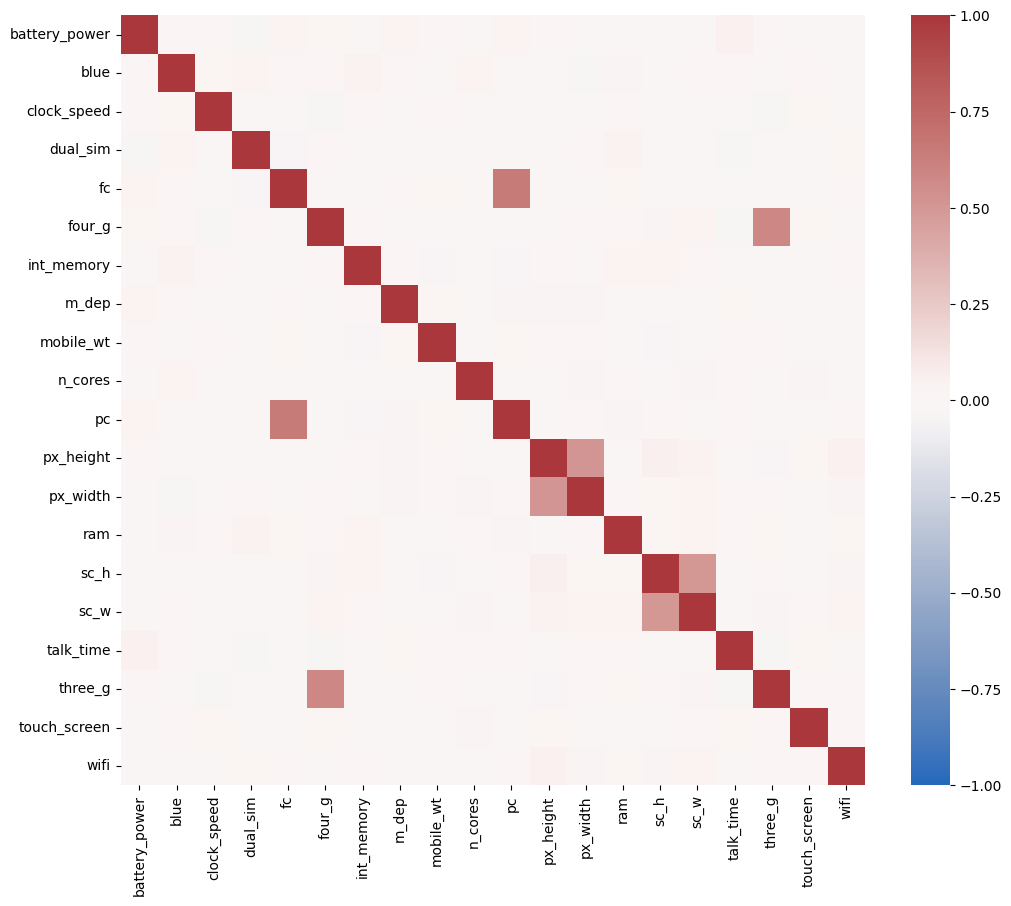

In [ ]:
plotCorr(per_corr)

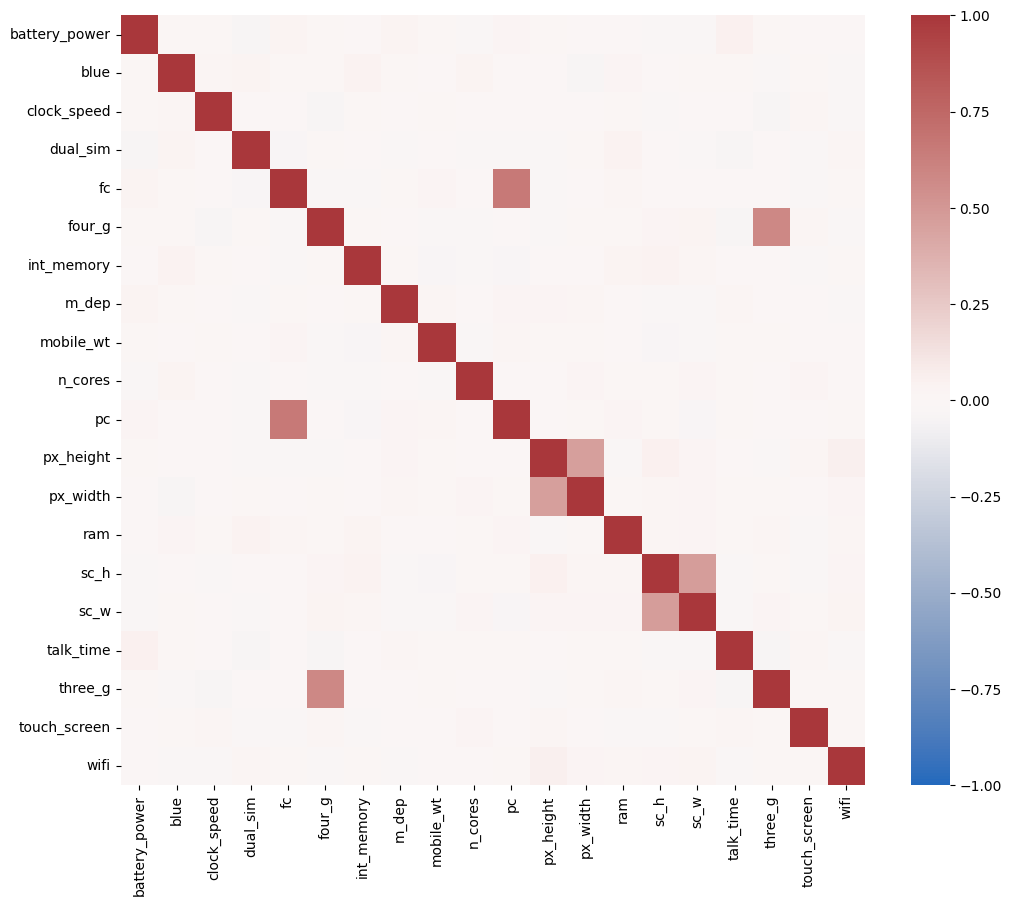

In [ ]:
plotCorr(spear_corr)

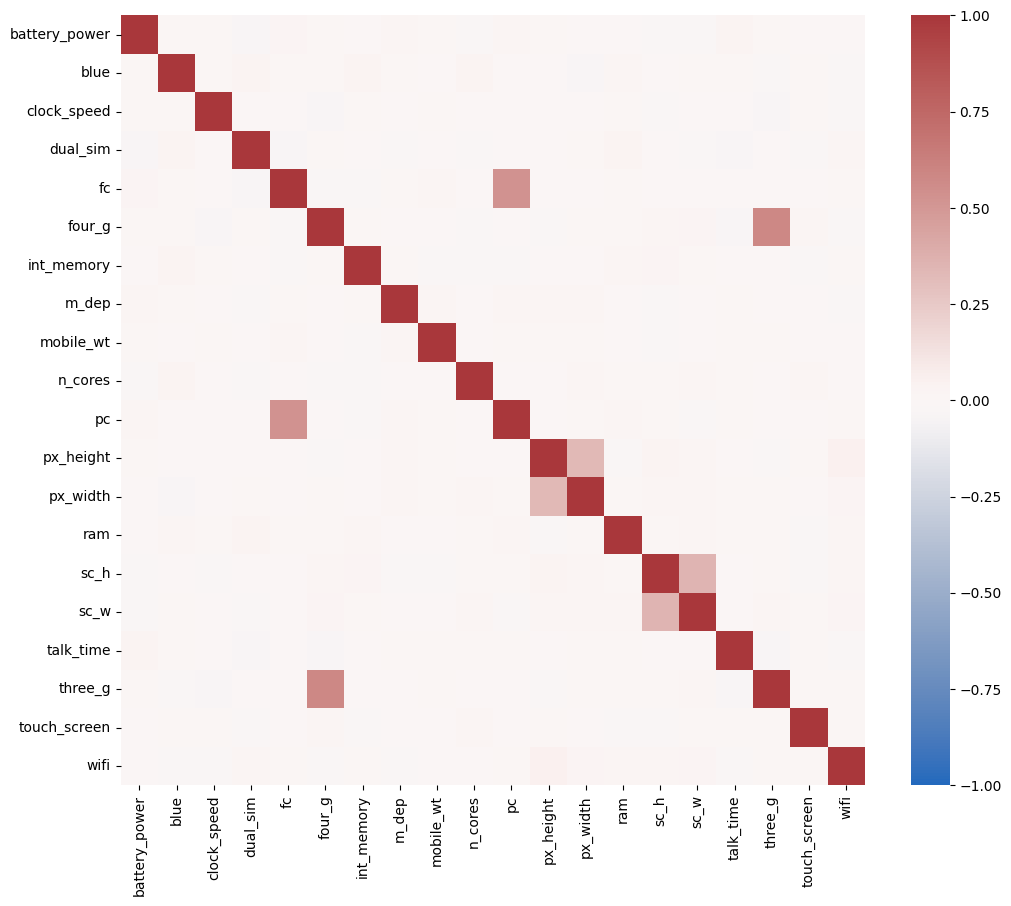

In [ ]:
plotCorr(kend_corr)

There is no difference in plots of three different types of correlation.


Let's plot graphs to explore correlation.



<Axes: xlabel='pc', ylabel='fc'>

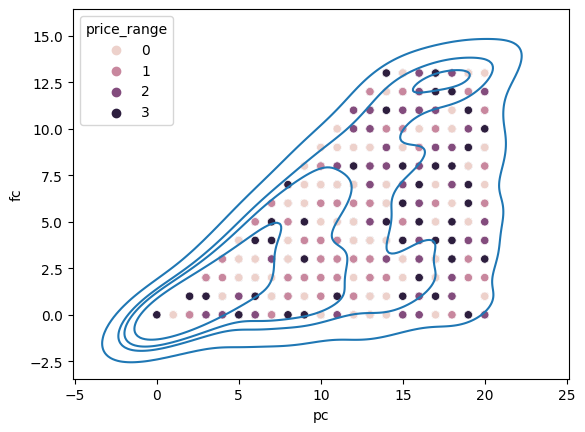

In [ ]:
sns.scatterplot(x=data.pc, y=data.fc, hue=data.price_range)
sns.kdeplot(x=data.pc, y=data.fc, levels=5)

<Axes: xlabel='sc_w', ylabel='sc_h'>

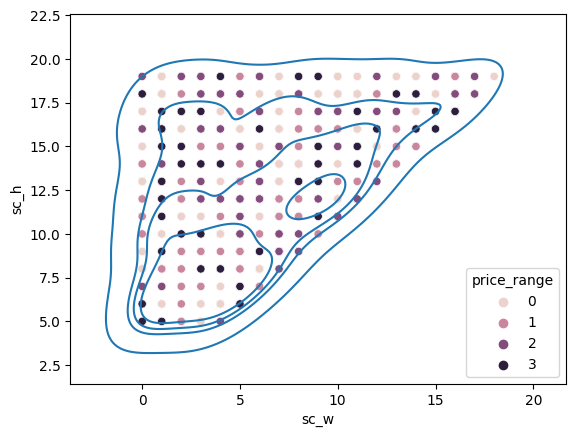

In [ ]:
sns.scatterplot(x=data.sc_w, y=data.sc_h, hue=data.price_range)
sns.kdeplot(x=data.sc_w, y=data.sc_h, levels=5)

<Axes: xlabel='px_width', ylabel='px_height'>

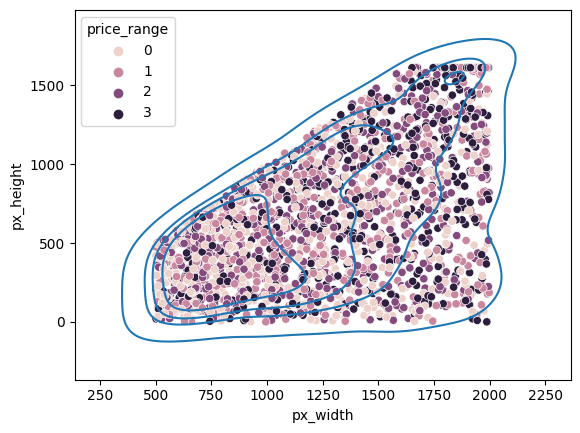

In [ ]:
sns.scatterplot(x=data.px_width, y=data.px_height, hue=data.price_range)
sns.kdeplot(x=data.px_width, y=data.px_height, levels=5)

There is no linear correlation and there is no straightforward non linear relationship.


Maximum value of px_height,  sc_w and fc growth with the growth of px_width, sc_h and pc respectfully.


On plots of px_height with px_width and fc with pc, although there is no linear relationship it is visible on kde plots, that observation tends to cluster to linear relationship, unlike on sc_w with sc_h plot.


Visible it is hard to differentiate classes based on provided plots.



<Axes: xlabel='four_g', ylabel='count'>

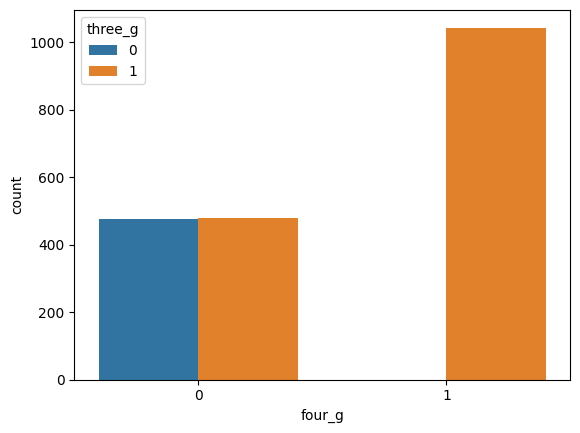

In [ ]:
sns.countplot(x=data.four_g, hue=data.three_g)

By ploting such graph we aquired valuable insigt, that in our data if telephone has four_g, than it also has three_g, that explain correlation.

<ipython-input-20-26b6afa05ae6>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pd.plotting.scatter_matrix(data[nonboolean_variables], figsize=(20, 20))


array([[<Axes: xlabel='px_width', ylabel='px_width'>,
        <Axes: xlabel='m_dep', ylabel='px_width'>,
        <Axes: xlabel='clock_speed', ylabel='px_width'>,
        <Axes: xlabel='sc_w', ylabel='px_width'>,
        <Axes: xlabel='talk_time', ylabel='px_width'>,
        <Axes: xlabel='int_memory', ylabel='px_width'>,
        <Axes: xlabel='px_height', ylabel='px_width'>,
        <Axes: xlabel='fc', ylabel='px_width'>,
        <Axes: xlabel='n_cores', ylabel='px_width'>,
        <Axes: xlabel='sc_h', ylabel='px_width'>,
        <Axes: xlabel='battery_power', ylabel='px_width'>,
        <Axes: xlabel='mobile_wt', ylabel='px_width'>,
        <Axes: xlabel='pc', ylabel='px_width'>,
        <Axes: xlabel='ram', ylabel='px_width'>],
       [<Axes: xlabel='px_width', ylabel='m_dep'>,
        <Axes: xlabel='m_dep', ylabel='m_dep'>,
        <Axes: xlabel='clock_speed', ylabel='m_dep'>,
        <Axes: xlabel='sc_w', ylabel='m_dep'>,
        <Axes: xlabel='talk_time', ylabel='m_dep'>,
       

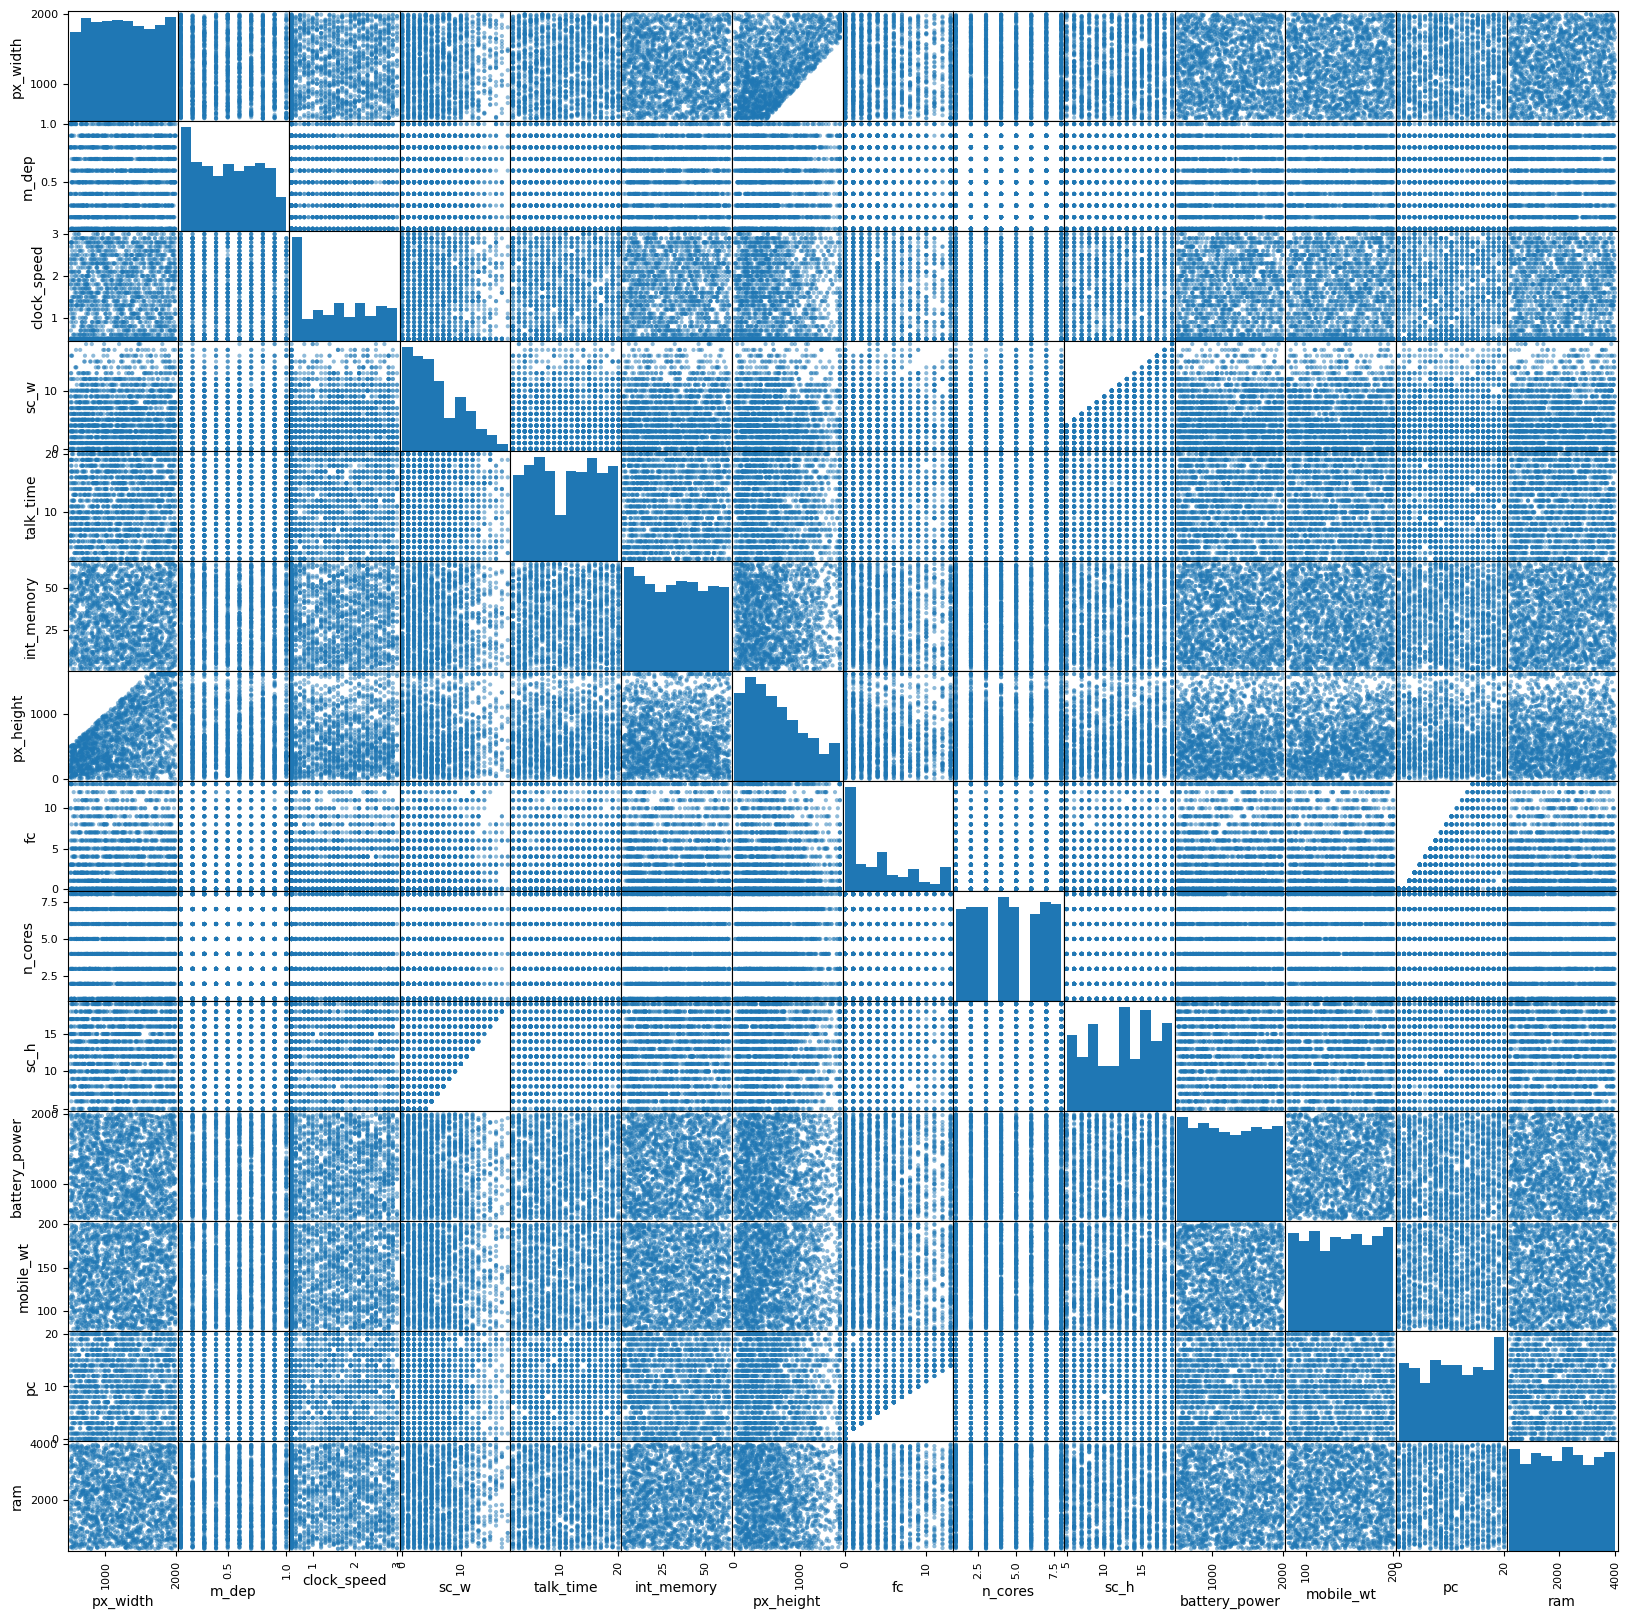

In [ ]:
pd.plotting.scatter_matrix(data[nonboolean_variables], figsize=(20, 20))

Visible analysis suggests that we did not miss any relationship between variables during correlation analysis.

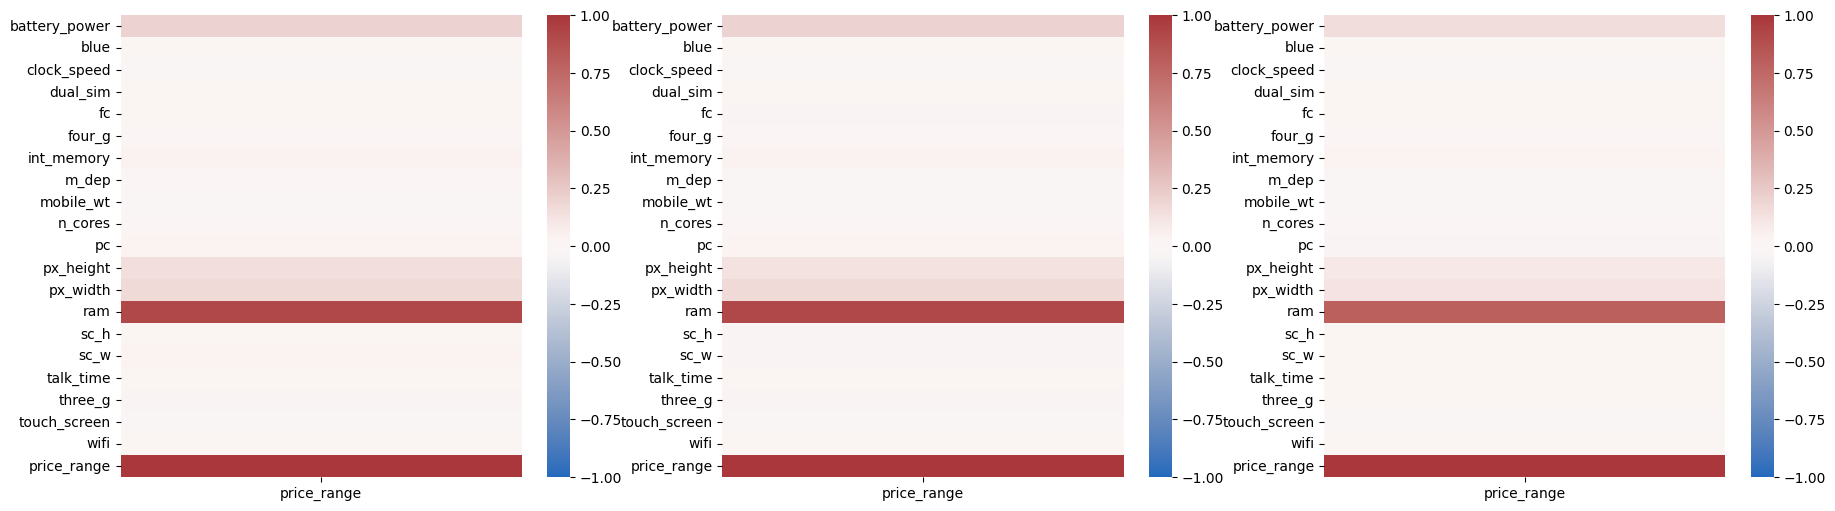

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [ ]:
per_corr = data.corr()[[response]]
spear_corr = data.corr('spearman')[[response]]
kend_corr = data.corr('kendall')[[response]]
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plotCorr(per_corr, ax=ax1)
plotCorr(spear_corr,ax=ax2)
plotCorr(kend_corr,ax=ax3)

Correlation analysis confirms our suggestions of ram importance, it also suggests some existence of importance of px_height, px_width and battery_power, that has no visible confirmation.

# Feature Engineering

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
import statsmodels.api as sm

# Helper function to get X and y from data
def get_train_test_data(data, predictors, response):
  X = data[predictors].to_numpy()
  y = data[response].to_numpy()
  return X, y

# Provides logistic regression prefomance based on 5-Fold CV
def get_baseline_score(data, predictors, response):
  X_train, y_train = get_train_test_data(data, predictors, response)

  with warnings.catch_warnings(record=True) as w:
    clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train, np.squeeze(y_train))
    score = np.mean(cross_val_score(clf, X_train, y_train))
    return score

We choose Logistic Regression as a baseline model for Feature Engineering, because it provides robust estimation of parameters.

In [ ]:
get_baseline_score(data, predictors, response)

0.6890000000000001

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data[predictors] = MinMaxScaler().fit_transform(data[predictors])

get_baseline_score(data, predictors, response)

0.9235

In [ ]:
data['px_area'] = data.px_height * data.px_width
predictors = predictors.append(pd.Index(['px_area']))
get_baseline_score(data, predictors, response)

0.924

In [ ]:
data['sc_area'] = data.sc_w * data.sc_h
predictors = predictors.append(pd.Index(['sc_area'])).drop('px_area')
get_baseline_score(data, predictors, response)

0.9244999999999999

In [ ]:
data['m_depXn_cores'] = data.m_dep * data.n_cores
predictors = predictors.append(pd.Index(['m_depXn_cores']))
get_baseline_score(data, predictors, response)

0.925

In [ ]:
data['clock_speedXn_cores'] = data.clock_speed * data.n_cores
predictors = predictors.append(pd.Index(['clock_speedXn_cores'])).drop('m_depXn_cores')
get_baseline_score(data, predictors, response)

0.924

In [ ]:
data['fcXpc'] = data.fc * data.pc
predictors = predictors.append(pd.Index(['fcXpc'])).drop('clock_speedXn_cores')
get_baseline_score(data, predictors, response)

0.921

In [ ]:
data['ramXram'] = data.ram * data.ram
predictors = predictors.append(pd.Index(['ramXram'])).drop('fcXpc')
baseline = get_baseline_score(data, predictors, response)
baseline

0.931

In [ ]:
# Visualizes improvement of model performance after adding a feature
def visualize_feature_engineering(results, baseline):
  results = pd.Series(results)
  results = results- baseline
  results = results[results > 0]

  results.plot.bar()


results = {}
for non_bool in nonboolean_variables :
  if non_bool != 'ram':
     data[f"{non_bool}X{non_bool}"] = data[non_bool] * data[non_bool]
     predictors = predictors.append(pd.Index([f"{non_bool}X{non_bool}"]))
     print(f"{non_bool}X{non_bool}")
     results[f"{non_bool}X{non_bool}"] = get_baseline_score(data, predictors, response)
     print(results[f"{non_bool}X{non_bool}"])
     predictors = predictors.drop(f"{non_bool}X{non_bool}")
     print()

px_widthXpx_width

m_depXm_dep

clock_speedXclock_speed

sc_wXsc_w

talk_timeXtalk_time

int_memoryXint_memory

px_heightXpx_height

fcXfc

n_coresXn_cores

sc_hXsc_h

battery_powerXbattery_power

mobile_wtXmobile_wt

pcXpc



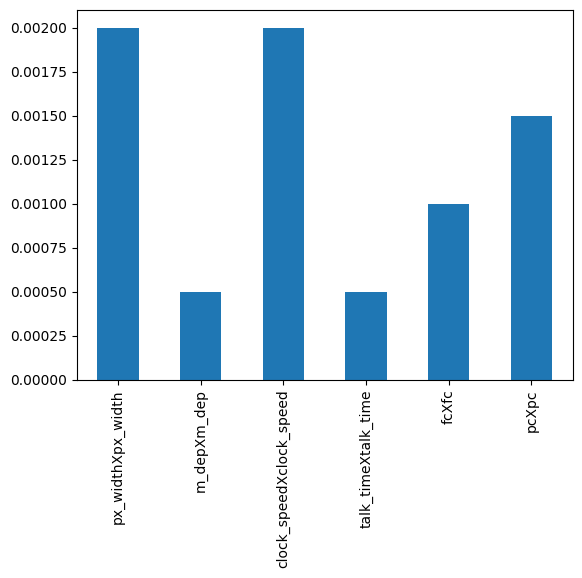

In [ ]:
visualize_feature_engineering(results, baseline)

In [ ]:
predictors = predictors.append(pd.Index(['px_widthXpx_width']))
baseline = get_baseline_score(data, predictors, response)
baseline

0.933

In [ ]:
results = {}
for bool_var in boolean_variables:
  for non_bool in nonboolean_variables:
     data[f"{bool_var}X{non_bool}"] = data[bool_var] * data[non_bool]
     predictors = predictors.append(pd.Index([f"{bool_var}X{non_bool}"]))
     print(f"{bool_var}X{non_bool}")
     results[f"{bool_var}X{non_bool}"] = get_baseline_score(data, predictors, response)
     print(results[f"{bool_var}X{non_bool}"])
     predictors = predictors.drop(f"{bool_var}X{non_bool}")
     print()

blueXpx_width
0.933

blueXm_dep
0.9344999999999999

blueXclock_speed
0.9315

blueXsc_w
0.9315

blueXtalk_time
0.93

blueXint_memory
0.9295

blueXpx_height
0.9339999999999999

blueXfc
0.9315

blueXn_cores
0.932

blueXsc_h
0.9315

blueXbattery_power
0.9334999999999999

blueXmobile_wt
0.9315000000000001

blueXpc
0.9319999999999998

blueXram
0.9279999999999999

dual_simXpx_width
0.9339999999999999

dual_simXm_dep
0.9315

dual_simXclock_speed
0.9315000000000001

dual_simXsc_w
0.9324999999999999

dual_simXtalk_time
0.933

dual_simXint_memory
0.9315

dual_simXpx_height
0.9324999999999999

dual_simXfc
0.9305

dual_simXn_cores
0.931

dual_simXsc_h
0.9309999999999998

dual_simXbattery_power
0.932

dual_simXmobile_wt
0.9315000000000001

dual_simXpc
0.9315

dual_simXram
0.9339999999999999

four_gXpx_width
0.9324999999999999

four_gXm_dep
0.9315

four_gXclock_speed
0.9335000000000001

four_gXsc_w
0.9339999999999999

four_gXtalk_time
0.9324999999999999

four_gXint_memory
0.9339999999999999

four_gXp

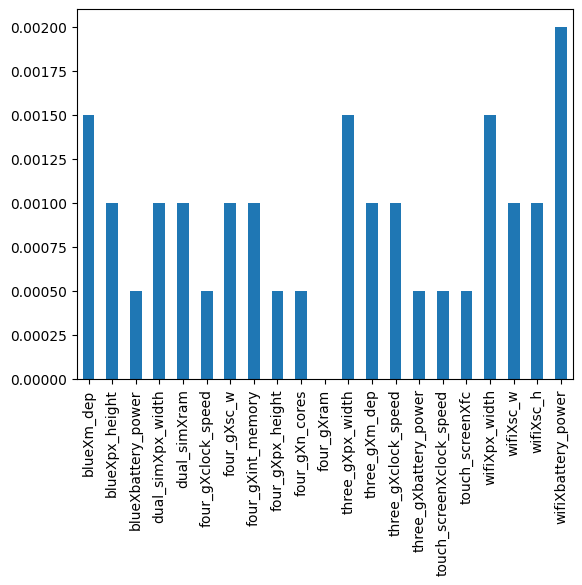

In [ ]:
visualize_feature_engineering(results, baseline)

In [ ]:
predictors = predictors.append(pd.Index(['wifiXbattery_power']))
get_baseline_score(data, predictors, response)

0.9350000000000002

In [ ]:
predictors = predictors.append(pd.Index(['blueXm_dep']))
get_baseline_score(data, predictors, response)

0.9339999999999999

In [ ]:
predictors = predictors.append(pd.Index(['wifiXpx_width'])).drop('blueXm_dep')
get_baseline_score(data, predictors, response)

0.9335000000000001

In [ ]:
predictors = predictors.append(pd.Index(['three_gXpx_width'])).drop('wifiXpx_width')
get_baseline_score(data, predictors, response)

0.9324999999999999

In [ ]:
predictors = predictors.drop('three_gXpx_width')
get_baseline_score(data, predictors, response)

0.9350000000000002

#Models hyper-parameters selectiom

We will experiment with three models.




LogisticRegresion - robust model for classification task


XGBoost - model that is able to solve non linear tasks, but also poses strong regularization tools




LDA - robust model, that also can be used for visualization of solution


At the end we will try to use VotingAssemble to see if it will result in any of performance increase


In [ ]:
# Some suggested values for hyper-parameters

log_grid = {
        'penalty': ['l1', 'l2'],
        'C': [1, 0.5, 0.1, 0.05, 0.01]
    }

lda_grid = {
    'priors': [tuple(np.random.dirichlet(np.ones(4),size=1)) for _ in range(16)] + [(0.25, 0.25, 0.25, 0.25), None]
}


xgb_first_grid = {
    'n_estimators' : [10, 50, 100, 250],
    'max_depth': [5, 10, 25, None],
}

xgb_second_grid = {
    'alpha' : [0, 0.5, 1],
    'lambda': [1, 2.5, 5, 10]
}

voting_grid = {
     'weights': [np.random.dirichlet(np.ones(2), size=1)[0] for _ in range(9)] + [(0.5, 0.5)]  + [(0.75, 0.25)] + [(0.25, 0.75)] + [(1, 0)] + [(0, 1)]
}

In [ ]:
from xgboost import XGBClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis

# Defines Logistic Regression model and returns its score based on 10-Fold CV
def get_log_score(data, predictors, response):
  X_train, y_train = get_train_test_data(data, predictors, response)

  with warnings.catch_warnings(record=True) as w:
    clf = LogisticRegression(random_state=0, max_iter=2500, class_weight='balanced', solver='saga').fit(X_train, np.squeeze(y_train))
    score = np.mean(cross_val_score(clf, X_train, y_train, cv=10))
    print(score)
    return score

# Defines XGBoost model and returns its score based on 10-Fold CV
def get_xgb_score(data, predictors, response):
  X_train, y_train = get_train_test_data(data, predictors, response)

  with warnings.catch_warnings(record=True) as w:
    bst = XGBClassifier(n_estimators=100, objective='multi:softmax')
    bst.fit(X_train, y_train)
    score = np.mean(cross_val_score(bst, X_train, y_train, cv=10))
    print(score)
    return score

# Defines LinearDiscriminantAnalysis model and returns its score based on 10-Fold CV
def get_lda_score(data, predictors, response):
    X_train, y_train = get_train_test_data(data, predictors, response)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train.flatten())
    score = np.mean(cross_val_score(lda, X_train, y_train.flatten(), cv=10))
    print(score)
    return score

In [ ]:
get_xgb_score(data, predictors, response)

0.9149999999999998


0.9149999999999998

In [ ]:
get_log_score(data, predictors, response)

0.9365


0.9365

In [ ]:
get_lda_score(data, predictors, response)

0.8995


0.8995

In [ ]:
from sklearn.model_selection import GridSearchCV

# Function that returns best model after applying Hyper-Parametr GridSearch with 10-Fold CV
def get_best_model(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)

    grid_search.fit(X_train, y_train)

    for params, mean, rank in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['rank_test_score']):
      print(params, mean, rank)

    return grid_search.best_estimator_

# Helper function that invokes get_best_model
def grid_search(data, predictors, response, model, grid):
  X_train, y_train = get_train_test_data(data, predictors, response)

  model = get_best_model(X_train, y_train.flatten(), model, grid)
  print()
  print('-'*30)
  print()
  print(np.mean(cross_val_score(model, X_train, y_train.flatten(), cv=10)))
  return model

In [ ]:
xgb = XGBClassifier(n_estimators=100, objective='multi:softmax')
xgb = grid_search(data, predictors, response, xgb, xgb_first_grid)
xgb = grid_search(data, predictors, response, xgb, xgb_second_grid)

{'max_depth': 5, 'n_estimators': 10} 0.893 16
{'max_depth': 5, 'n_estimators': 50} 0.9145 6
{'max_depth': 5, 'n_estimators': 100} 0.917 1
{'max_depth': 5, 'n_estimators': 250} 0.9155000000000001 3
{'max_depth': 10, 'n_estimators': 10} 0.8965 15
{'max_depth': 10, 'n_estimators': 50} 0.9105000000000001 11
{'max_depth': 10, 'n_estimators': 100} 0.9139999999999999 8
{'max_depth': 10, 'n_estimators': 250} 0.9135000000000002 9
{'max_depth': 25, 'n_estimators': 10} 0.9029999999999999 13
{'max_depth': 25, 'n_estimators': 50} 0.9109999999999999 10
{'max_depth': 25, 'n_estimators': 100} 0.917 1
{'max_depth': 25, 'n_estimators': 250} 0.915 4
{'max_depth': None, 'n_estimators': 10} 0.9004999999999999 14
{'max_depth': None, 'n_estimators': 50} 0.909 12
{'max_depth': None, 'n_estimators': 100} 0.9149999999999998 5
{'max_depth': None, 'n_estimators': 250} 0.9145 6

------------------------------

0.917
{'alpha': 0, 'lambda': 1} 0.917 2
{'alpha': 0, 'lambda': 2.5} 0.916 5
{'alpha': 0, 'lambda': 5} 0.9

In [ ]:
lda = LinearDiscriminantAnalysis()
lda = grid_search(data, predictors, response, lda, lda_grid)

{'priors': (array([0.51742905, 0.03935475, 0.20931621, 0.2339    ]),)} 0.867 9
{'priors': (array([0.03278079, 0.51320953, 0.19968249, 0.2543272 ]),)} 0.8665 10
{'priors': (array([0.23927184, 0.26656833, 0.4828227 , 0.01133712]),)} 0.8424999999999999 14
{'priors': (array([0.03487434, 0.27618272, 0.03454312, 0.65439982]),)} 0.841 15
{'priors': (array([0.26527832, 0.11526906, 0.28792199, 0.33153063]),)} 0.8860000000000001 5
{'priors': (array([0.61492806, 0.060262  , 0.08387165, 0.24093829]),)} 0.9010000000000001 2
{'priors': (array([0.13574659, 0.27873027, 0.05861874, 0.5269044 ]),)} 0.8805 7
{'priors': (array([0.04560545, 0.50483234, 0.38029499, 0.06926722]),)} 0.858 12
{'priors': (array([0.0052313 , 0.48918109, 0.07233086, 0.43325674]),)} 0.8215 18
{'priors': (array([0.48120705, 0.06174302, 0.22527512, 0.23177481]),)} 0.876 8
{'priors': (array([0.06438945, 0.05132   , 0.40712462, 0.47716593]),)} 0.8545 13
{'priors': (array([0.18715168, 0.10932325, 0.05672702, 0.64679805]),)} 0.902999999

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=2500, class_weight='balanced', solver='saga')
clf = grid_search(data, predictors, response, clf, log_grid)

{'C': 1, 'penalty': 'l1'} 0.9664999999999999 1
{'C': 1, 'penalty': 'l2'} 0.9365 3
{'C': 0.5, 'penalty': 'l1'} 0.9549999999999998 2
{'C': 0.5, 'penalty': 'l2'} 0.9195 4
{'C': 0.1, 'penalty': 'l1'} 0.8790000000000001 5
{'C': 0.1, 'penalty': 'l2'} 0.8494999999999999 6
{'C': 0.05, 'penalty': 'l1'} 0.829 7
{'C': 0.05, 'penalty': 'l2'} 0.8035 8
{'C': 0.01, 'penalty': 'l1'} 0.5910000000000001 10
{'C': 0.01, 'penalty': 'l2'} 0.7044999999999999 9

------------------------------

0.9664999999999999


In [ ]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[('log', clf),  ('xgb', xgb)])
voting = grid_search(data, predictors, response, voting, voting_grid)

# Conclusion

Although we stated that accuracy metric is enough, bacause our dataset is balanced we can still benefit from viewing othr metrics.

In [ ]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[response], test_size=0.33)

clf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lda.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

In [ ]:
print(classification_report(y_test, xgb.predict(X_test)))

In [ ]:
print(classification_report(y_test, lda.predict(X_test)))

In conclusion LogisicRegresion resulted in best performance.


As we stated accuracy provided reasonable estimation of performance, that is close to Precision, Recall and F1-score metrics.


The only insight we could get is that class 2 and 3 are much harder to identify, which is suggested by performance statistics among all models, unlike class 1 and 4.